In [1]:
import os
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sn
from collections import Counter
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import ResNet50,EfficientNetB3
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras import regularizers

from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping

from IPython.display import Image, HTML
from tensorflow.keras.utils import plot_model

In [2]:
train_dir = '../input/fer2013/train/'
test_dir = '../input/fer2013/test/'

# Image size

IMAGE_SIZE = (48,48)
IMAGE_SHAPE = IMAGE_SIZE + (3,)

BS = 64
EPOCHS = 100
ADAM_LEARNING_RATE = 0.0001
PATIENCE =10

classes=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [4]:
train_dataset  = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = IMAGE_SIZE,
                                                   class_mode = 'categorical',
                                                   batch_size = BS)

test_dataset = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = IMAGE_SIZE,
                                                  class_mode = 'categorical',
                                                  shuffle =True,
                                                  batch_size = BS)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [5]:
import os
import pandas as pd
from IPython.core.display import HTML

def count_exp(path, set_):
    dict_ = {}
    if not os.path.exists(path):
        raise ValueError(f"Path does not exist: {path}")
    
    for expression in os.listdir(path):
        dir_ = os.path.join(path, expression)  # Use os.path.join for cross-platform compatibility
        if os.path.isdir(dir_):  # Ensure it's a directory
            dict_[expression] = len(os.listdir(dir_))
    
    return pd.DataFrame(dict_, index=[set_])

# Ensure train_dir and test_dir are correctly defined
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')

# Fix the append issue
HTML(pd.concat([train_count, test_count]).to_html(escape=False))


,surprise,fear,angry,neutral,sad,disgust,happy
train,3171,4097,3995,4965,4830,436,7215
test,831,1024,958,1233,1247,111,1774


In [6]:
class_labels = test_dataset.class_indices
class_labels

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [7]:
train_sample=next(train_dataset)
print(train_sample[0].shape)

(64, 48, 48, 3)


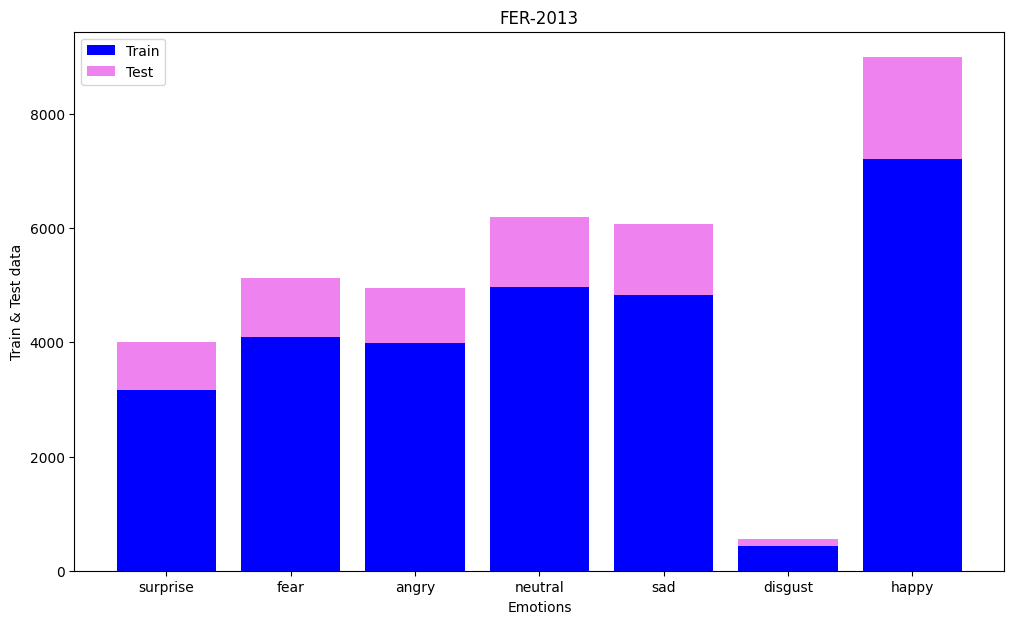

In [8]:
x = list(test_count.columns)
y1 =train_count.iloc[0].to_list()
y2 = test_count.iloc[0].to_list()
plt.figure(figsize=(12,7))

plt.bar(x, y1, color='blue')
plt.bar(x, y2, bottom=y1, color='violet')
plt.xlabel("Emotions")
plt.ylabel("Train & Test data")
plt.legend(["Train", "Test"], loc='upper left')
plt.title("FER-2013")
plt.savefig('distribution.png')
plt.show()

# 1. EfficientNetB3

In [9]:
base_model = EfficientNetB3(input_shape=IMAGE_SHAPE, include_top=False, weights='imagenet')
base_model.trainable = False

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
model=Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(GaussianNoise(0.01))
model.add(GlobalAveragePooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(7, activation="softmax"))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 2, 2, 1536)          │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2, 2, 1536)          │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise (GaussianNoise)       │ (None, 2, 2, 1536)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,218,486 (42.80 MB)

 Trainable params: 431,111 (1.64 MB)

 Non-trainable params: 10,787,375 (41.15 MB)

In [11]:
# Compile model

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

adam = tf.keras.optimizers.Adam(learning_rate=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=METRICS)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [12]:
# Run Model

counter = Counter(train_dataset.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : round(max_val/num_images,2) for class_id, num_images in counter.items()}  

lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = PATIENCE,verbose = 1,factor = 0.50, min_lr = 1e-10)
mcp = ModelCheckpoint('model_efficient_net_B3.keras')
es = EarlyStopping(verbose=1, patience=20)

history=model.fit(train_dataset,
                  validation_data=test_dataset,
                  epochs = EPOCHS,
                  verbose =1,
                  callbacks = [lrd,mcp,es], 
                  class_weight = class_weights)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 249s 470ms/step - accuracy: 0.8147 - auc: 0.5007 - f1_score: 0.0846 - loss: 5.6269 - precision: 0.1442 - recall: 0.0603 - val_accuracy: 0.8571 - val_auc: 0.4316 - val_f1_score: 0.0000e+00 - val_loss: 2.6895 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 63s 138ms/step - accuracy: 0.8251 - auc: 0.4971 - f1_score: 0.0621 - loss: 5.2493 - precision: 0.1333 - recall: 0.0408 - val_accuracy: 0.8571 - val_auc: 0.4373 - val_f1_score: 0.0000e+00 - val_loss: 2.6383 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 63s 138ms/step - accuracy: 0.8314 - auc: 0.5042 - f1_score: 0.0530 - loss: 5.0339 - precision: 0.1345 - recall: 0.0332 - val_accuracy: 0.8571 - val_auc: 0.4465 - val_f1_score: 0.0000e+00 - val_loss: 2.6088 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/100
449/449 ━━━━━━━

In [13]:
model.save("/kaggle/working/model_efficient_net_B3.h5")

In [14]:
train_evalation = model.evaluate(train_dataset)
test_evaluation = model.evaluate(test_dataset)

449/449 ━━━━━━━━━━━━━━━━━━━━ 58s 128ms/step - accuracy: 0.8571 - auc: 0.4940 - f1_score: 0.0000e+00 - loss: 1.9593 - precision: 0.0000e+00 - recall: 0.0000e+00
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.8571 - auc: 0.5004 - f1_score: 0.0000e+00 - loss: 1.9586 - precision: 0.0000e+00 - recall: 0.0000e+00


In [15]:
metric_list = ["Loss","Accuracy", "Precision", "Recall", "Auc", "F1_Score"]

df = pd.DataFrame(list(zip(metric_list, 
                           [round(num, 3) for num in train_evalation], 
                           [round(num, 3) for num in test_evaluation])),
                  columns=['Metric Name', 'Train', 'Validate'])

print('\n\nModel Scores\n')

HTML(df.to_html(escape=False))



Model Scores



,Metric Name,Train,Validate
0,Loss,1.959,1.959
1,Accuracy,0.857,0.857
2,Precision,0.000,0.000
3,Recall,0.000,0.000
4,Auc,0.495,0.501
5,F1_Score,0.000,0.000


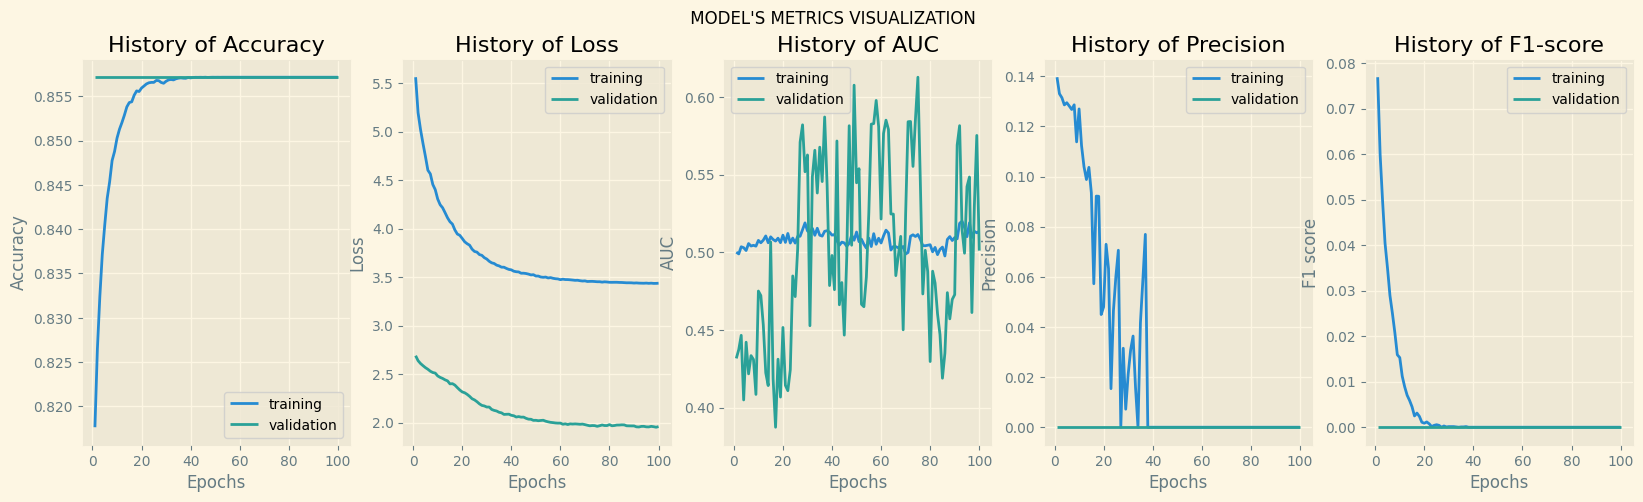

In [16]:
hs=history.history

acc = hs['accuracy']
val_acc = hs['val_accuracy']
loss =  hs['loss']
val_loss = hs['val_loss']
auc =  hs['auc']
val_auc = hs['val_auc']
precision =hs['precision']
val_precision =hs['val_precision']
f1 = hs['f1_score']
val_f1 = hs['val_f1_score']              

plt.style.use('Solarize_Light2')

fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

ax1.plot(range(1, len(acc) + 1), acc)
ax1.plot(range(1, len(val_acc) + 1), val_acc)
ax1.set_title('History of Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(['training', 'validation'])


ax2.plot(range(1, len(loss) + 1), loss)
ax2.plot(range(1, len(val_loss) + 1), val_loss)
ax2.set_title('History of Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(['training', 'validation'])

ax3.plot(range(1, len(auc) + 1), auc)
ax3.plot(range(1, len(val_auc) + 1), val_auc)
ax3.set_title('History of AUC')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('AUC')
ax3.legend(['training', 'validation'])

ax4.plot(range(1, len(precision) + 1), precision)
ax4.plot(range(1, len(val_precision) + 1), val_precision)
ax4.set_title('History of Precision')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Precision')
ax4.legend(['training', 'validation'])

ax5.plot(range(1, len(f1) + 1), f1)
ax5.plot(range(1, len(val_f1) + 1), val_f1)
ax5.set_title('History of F1-score')
ax5.set_xlabel('Epochs')
ax5.set_ylabel('F1 score')
ax5.legend(['training', 'validation'])

plt.show()

In [17]:
y_true = test_dataset.classes
y_pred =  model.predict(test_dataset)
y_pred= tf.argmax(y_pred, axis = 1).numpy()

cm = confusion_matrix(y_true = y_true, y_pred = y_pred)

113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step


Confusion matrix, without normalization

[[   0    0   91    0  600    0  267]
 [   0    0   10    0   68    0   33]
 [   1    0  118    0  605    0  300]
 [   0    0  221    0 1045    0  508]
 [   1    0  144    0  711    0  377]
 [   1    1  132    0  749    0  364]
 [   1    0   81    0  492    0  257]]





<ipython-input-18-a56f347fa47c>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


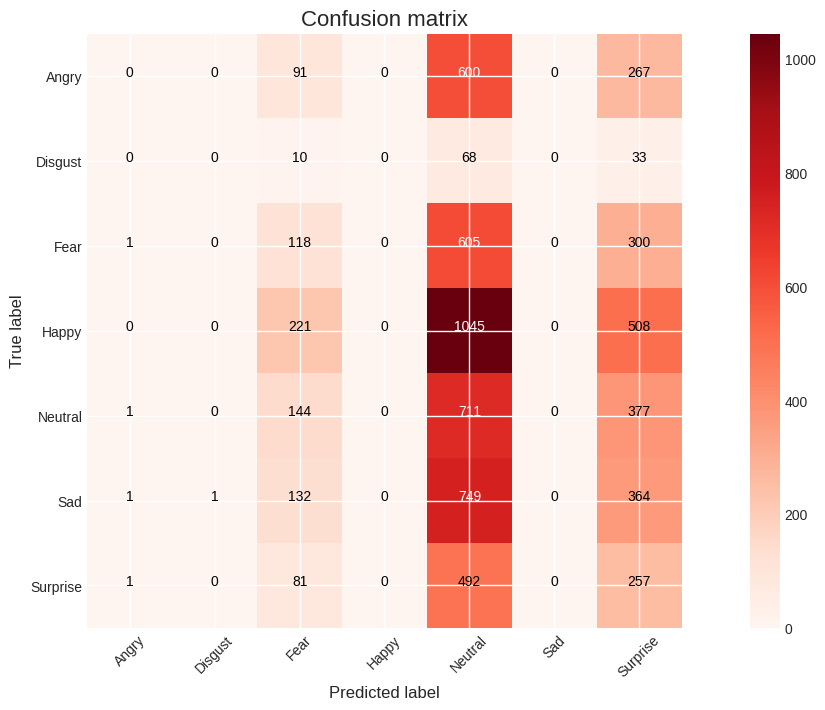

In [18]:
plt.rcParams['figure.figsize'] = (14,7)

plt.style.use('seaborn-darkgrid')
plt.imshow(cm, interpolation='nearest', cmap='Reds')
plt.title('Confusion matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)    

print('Confusion matrix, without normalization\n')   
print(cm)

print("\n\n")
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

<ipython-input-19-e68e0cb2e8fd>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


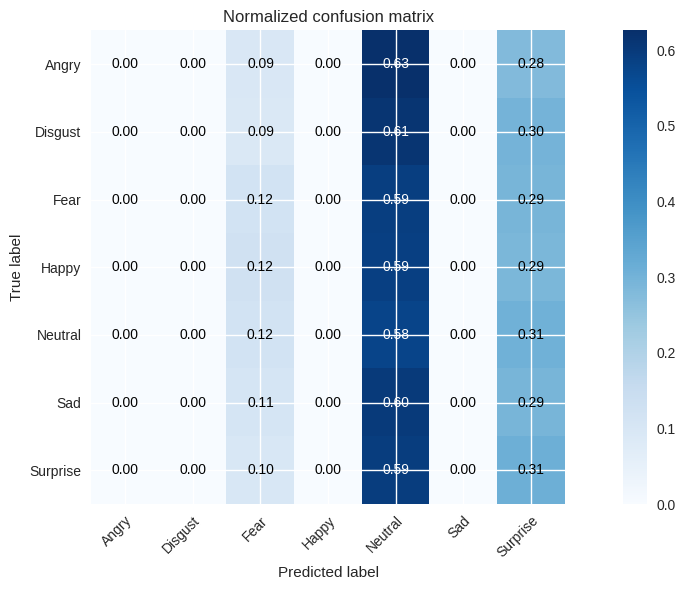

In [19]:
plt.style.use('seaborn')

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(12,6))

im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title = 'Normalized confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


fmt = '.2f' 
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()

# 2. ResNet50

In [20]:
base_model = tf.keras.applications.ResNet50(input_shape=IMAGE_SHAPE, include_top=False, weights="imagenet")
base_model.summary()

for layer in base_model.layers[:50]:
    layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 48, 48, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 54, 54, 3)      │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 24, 24, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 24, 24, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 24, 24, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 26, 26, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 12, 12, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 12, 12, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 12, 12, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 12, 12, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 12, 12, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 12, 12, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 12, 12, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 12, 12, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 12, 12, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [21]:
model=Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(GaussianNoise(0.01))
model.add(GlobalAveragePooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(7, activation="softmax"))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2, 2, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 2, 2, 2048)          │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise_1 (GaussianNoise)     │ (None, 2, 2, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,155,783 (92.15 MB)

 Trainable params: 23,490,311 (89.61 MB)

 Non-trainable params: 665,472 (2.54 MB)

In [22]:
# Compile model

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

adam = tf.keras.optimizers.Adam(learning_rate=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=METRICS)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [23]:
# Run Model

counter = Counter(train_dataset.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : round(max_val/num_images,2) for class_id, num_images in counter.items()}  

lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = PATIENCE,verbose = 1,factor = 0.50, min_lr = 1e-10)
mcp = ModelCheckpoint('model_ResNet50.keras')
es = EarlyStopping(verbose=1, patience=20)

history=model.fit(train_dataset,
                  validation_data=test_dataset,
                  epochs = EPOCHS,
                  verbose =1,
                  callbacks = [lrd,mcp,es], 
                  class_weight = class_weights)

Epoch 1/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 130s 190ms/step - accuracy: 0.8100 - auc: 0.5031 - f1_score: 0.0905 - loss: 5.8474 - precision: 0.1445 - recall: 0.0669 - val_accuracy: 0.8498 - val_auc: 0.5394 - val_f1_score: 0.0274 - val_loss: 2.8857 - val_precision: 0.1854 - val_recall: 0.0152 - learning_rate: 1.0000e-04
Epoch 2/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 61s 134ms/step - accuracy: 0.8384 - auc: 0.5232 - f1_score: 0.0524 - loss: 5.0359 - precision: 0.1624 - recall: 0.0315 - val_accuracy: 0.8448 - val_auc: 0.5717 - val_f1_score: 0.0713 - val_loss: 3.4050 - val_precision: 0.2480 - val_recall: 0.0425 - learning_rate: 1.0000e-04
Epoch 3/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 61s 134ms/step - accuracy: 0.8445 - auc: 0.5433 - f1_score: 0.0471 - loss: 4.7255 - precision: 0.1898 - recall: 0.0271 - val_accuracy: 0.8566 - val_auc: 0.5801 - val_f1_score: 0.0096 - val_loss: 2.5407 - val_precision: 0.3636 - val_recall: 0.0050 - learning_rate: 1.0000e-04
Epoch 4/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 61s 133ms/

In [24]:
model.save("/kaggle/working/model_ResNet50.h5")

In [25]:
train_evalation = model.evaluate(train_dataset)
test_evaluation = model.evaluate(test_dataset)

449/449 ━━━━━━━━━━━━━━━━━━━━ 60s 134ms/step - accuracy: 0.8694 - auc: 0.7939 - f1_score: 0.2719 - loss: 1.5815 - precision: 0.6650 - recall: 0.1723
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.8744 - auc: 0.8107 - f1_score: 0.3229 - loss: 1.5277 - precision: 0.6997 - recall: 0.2115


In [26]:
metric_list = ["Loss","Accuracy", "Precision", "Recall", "Auc", "F1_Score"]

df = pd.DataFrame(list(zip(metric_list, 
                           [round(num, 3) for num in train_evalation], 
                           [round(num, 3) for num in test_evaluation])),
                  columns=['Metric Name', 'Train', 'Validate'])

print('\n\nModel Scores\n')

HTML(df.to_html(escape=False))



Model Scores



,Metric Name,Train,Validate
0,Loss,1.580,1.515
1,Accuracy,0.870,0.875
2,Precision,0.673,0.704
3,Recall,0.174,0.214
4,Auc,0.794,0.815
5,F1_Score,0.275,0.326


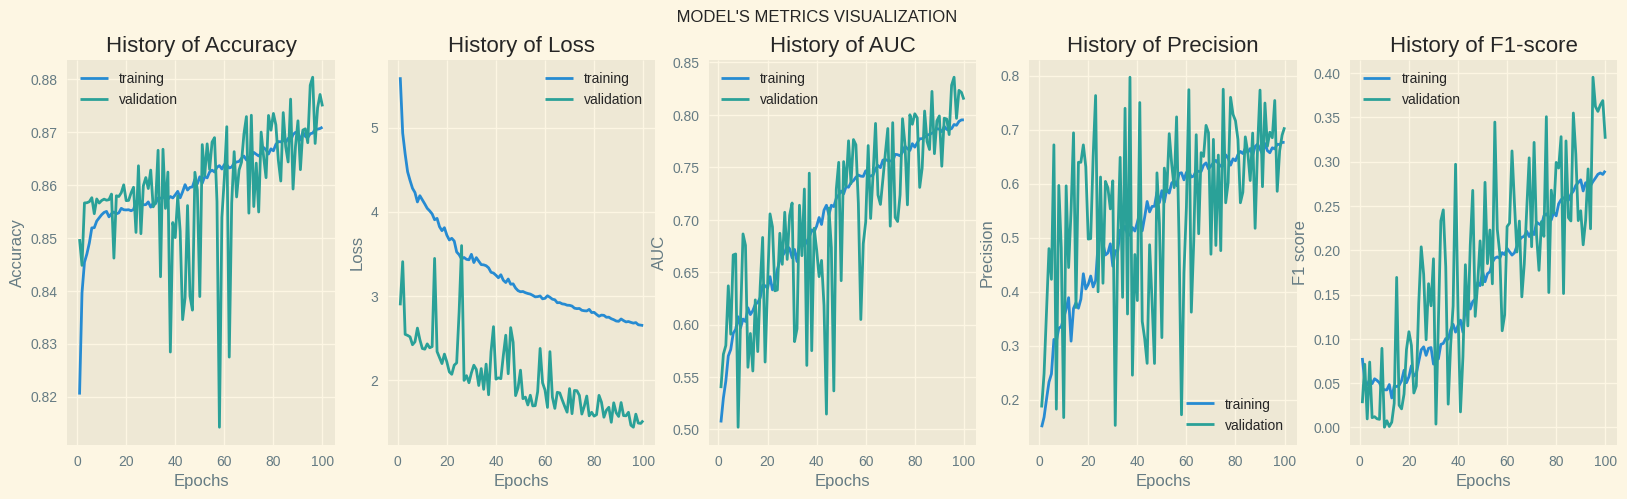

In [27]:
hs=history.history

acc = hs['accuracy']
val_acc = hs['val_accuracy']
loss =  hs['loss']
val_loss = hs['val_loss']
auc =  hs['auc']
val_auc = hs['val_auc']
precision =hs['precision']
val_precision =hs['val_precision']
f1 = hs['f1_score']
val_f1 = hs['val_f1_score']              

plt.style.use('Solarize_Light2')

fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

ax1.plot(range(1, len(acc) + 1), acc)
ax1.plot(range(1, len(val_acc) + 1), val_acc)
ax1.set_title('History of Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(['training', 'validation'])


ax2.plot(range(1, len(loss) + 1), loss)
ax2.plot(range(1, len(val_loss) + 1), val_loss)
ax2.set_title('History of Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(['training', 'validation'])

ax3.plot(range(1, len(auc) + 1), auc)
ax3.plot(range(1, len(val_auc) + 1), val_auc)
ax3.set_title('History of AUC')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('AUC')
ax3.legend(['training', 'validation'])

ax4.plot(range(1, len(precision) + 1), precision)
ax4.plot(range(1, len(val_precision) + 1), val_precision)
ax4.set_title('History of Precision')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Precision')
ax4.legend(['training', 'validation'])

ax5.plot(range(1, len(f1) + 1), f1)
ax5.plot(range(1, len(val_f1) + 1), val_f1)
ax5.set_title('History of F1-score')
ax5.set_xlabel('Epochs')
ax5.set_ylabel('F1 score')
ax5.legend(['training', 'validation'])

plt.show()

In [28]:
y_true = test_dataset.classes
y_pred =  model.predict(test_dataset)
y_pred= tf.argmax(y_pred, axis = 1).numpy()

cm = confusion_matrix(y_true = y_true, y_pred = y_pred)

113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step


Confusion matrix, without normalization

[[ 95 150  57 231 142 195  88]
 [  7  18   7  24  15  27  13]
 [ 91 142  43 245 164 235 104]
 [137 264  93 430 281 389 180]
 [ 98 180  68 293 183 274 137]
 [105 196  61 323 198 242 122]
 [ 69 123  32 198 127 202  80]]





<ipython-input-29-a56f347fa47c>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


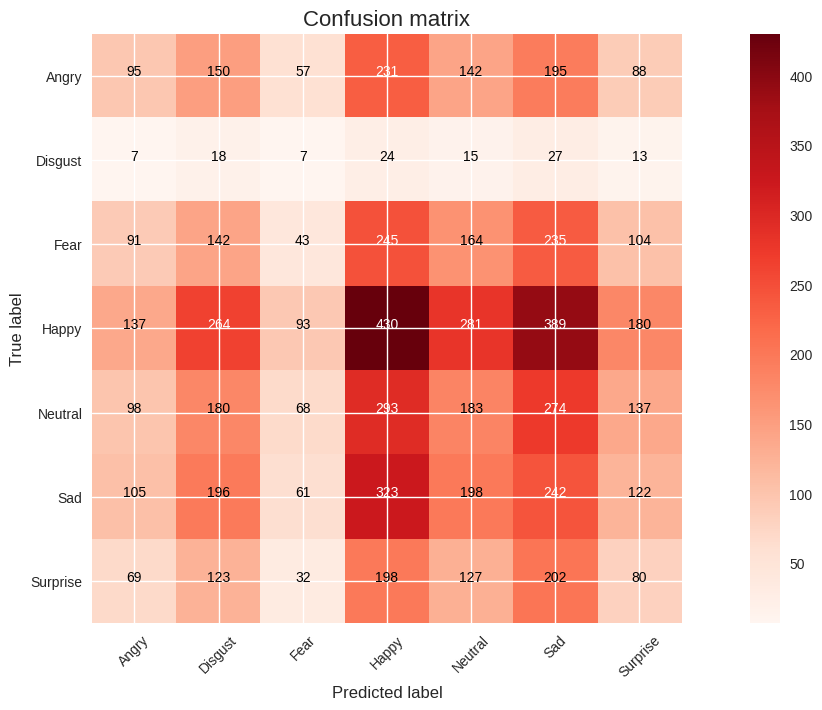

In [29]:
plt.rcParams['figure.figsize'] = (14,7)

plt.style.use('seaborn-darkgrid')
plt.imshow(cm, interpolation='nearest', cmap='Reds')
plt.title('Confusion matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)    

print('Confusion matrix, without normalization\n')   
print(cm)

print("\n\n")
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

<ipython-input-30-e68e0cb2e8fd>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


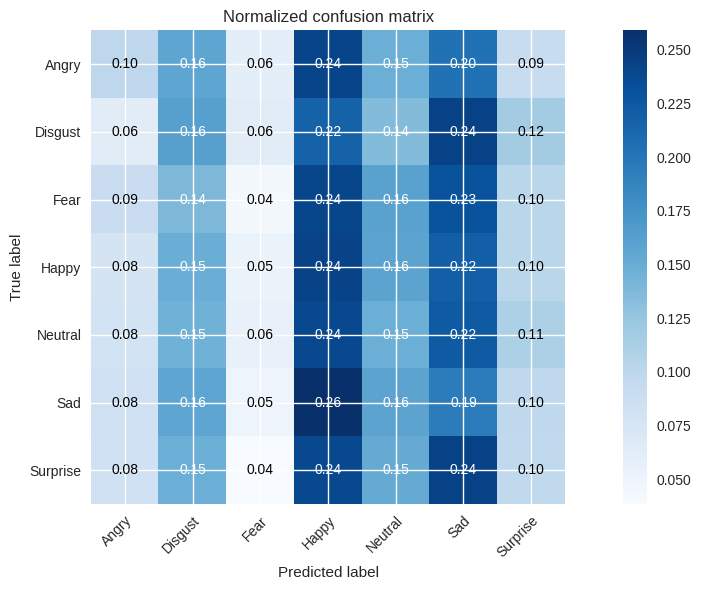

In [30]:
plt.style.use('seaborn')

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(12,6))

im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title = 'Normalized confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


fmt = '.2f' 
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()

# 3. Alex Net

In [31]:
# AlexNet Model
model = Sequential([
    Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=IMAGE_SHAPE),
    BatchNormalization(),
    MaxPooling2D((3, 3), strides=2),

    Conv2D(256, (5, 5), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((3, 3), strides=2),

    Conv2D(384, (3, 3), padding='same', activation='relu'),
    Conv2D(384, (3, 3), padding='same', activation='relu'),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((3, 3), strides=2),

    Flatten(),
    Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    
    Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    
    Dense(7, activation='softmax')
])

NameError: name 'Conv2D' is not defined

In [ ]:
# Compile model

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

adam = tf.keras.optimizers.Adam(learning_rate=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
# Run Model

counter = Counter(train_dataset.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : round(max_val/num_images,2) for class_id, num_images in counter.items()}  

lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = PATIENCE,verbose = 1,factor = 0.50, min_lr = 1e-10)
mcp = ModelCheckpoint('model_alexnet.keras')
es = EarlyStopping(verbose=1, patience=20)

history=model.fit(train_dataset,
                  validation_data=test_dataset,
                  epochs = EPOCHS,
                  verbose =1,
                  callbacks = [lrd,mcp,es], 
                  class_weight = class_weights)

In [ ]:
model.save("/kaggle/working/model_alex_net.h5")

In [ ]:
train_evalation = model.evaluate(train_dataset)
test_evaluation = model.evaluate(test_dataset)

In [ ]:
metric_list = ["Loss","Accuracy", "Precision", "Recall", "Auc", "F1_Score"]

df = pd.DataFrame(list(zip(metric_list, 
                           [round(num, 3) for num in train_evalation], 
                           [round(num, 3) for num in test_evaluation])),
                  columns=['Metric Name', 'Train', 'Validate'])

print('\n\nModel Scores\n')

HTML(df.to_html(escape=False))

In [ ]:
hs=history.history

acc = hs['accuracy']
val_acc = hs['val_accuracy']
loss =  hs['loss']
val_loss = hs['val_loss']
auc =  hs['auc']
val_auc = hs['val_auc']
precision =hs['precision']
val_precision =hs['val_precision']
f1 = hs['f1_score']
val_f1 = hs['val_f1_score']              

plt.style.use('Solarize_Light2')

fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

ax1.plot(range(1, len(acc) + 1), acc)
ax1.plot(range(1, len(val_acc) + 1), val_acc)
ax1.set_title('History of Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(['training', 'validation'])


ax2.plot(range(1, len(loss) + 1), loss)
ax2.plot(range(1, len(val_loss) + 1), val_loss)
ax2.set_title('History of Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(['training', 'validation'])

ax3.plot(range(1, len(auc) + 1), auc)
ax3.plot(range(1, len(val_auc) + 1), val_auc)
ax3.set_title('History of AUC')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('AUC')
ax3.legend(['training', 'validation'])

ax4.plot(range(1, len(precision) + 1), precision)
ax4.plot(range(1, len(val_precision) + 1), val_precision)
ax4.set_title('History of Precision')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Precision')
ax4.legend(['training', 'validation'])

ax5.plot(range(1, len(f1) + 1), f1)
ax5.plot(range(1, len(val_f1) + 1), val_f1)
ax5.set_title('History of F1-score')
ax5.set_xlabel('Epochs')
ax5.set_ylabel('F1 score')
ax5.legend(['training', 'validation'])

plt.show()

In [ ]:
y_true = test_dataset.classes
y_pred =  model.predict(test_dataset)
y_pred= tf.argmax(y_pred, axis = 1).numpy()

cm = confusion_matrix(y_true = y_true, y_pred = y_pred)

In [ ]:
plt.rcParams['figure.figsize'] = (14,7)

plt.style.use('seaborn-darkgrid')
plt.imshow(cm, interpolation='nearest', cmap='Reds')
plt.title('Confusion matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)    

print('Confusion matrix, without normalization\n')   
print(cm)

print("\n\n")
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
plt.style.use('seaborn')

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(12,6))

im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title = 'Normalized confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


fmt = '.2f' 
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()